In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import json 
import random 
from warnings import filterwarnings
filterwarnings('ignore')
import math
from datetime import datetime


In [27]:
config = json.loads(open('config.json').read()) 

train_set_path = config["local"]["train_set_path"]
test_set_path = config["local"]["test_set_path"]
val_set_path = config["local"]["val_set_path"]
model_path = config["local"]["model_path"]
train= False

In [49]:
# Data Augmentation and Rescaling for Training and Validation Sets
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)  # Just rescaling for validation data

# Create Training Set Generator
train_set = train_datagen.flow_from_directory(
    train_set_path,        # Path to the folder containing training images
    target_size=(150, 150),          # Resize images to 150x150
    batch_size=32,                   # Process 32 images per batch
    class_mode='binary'              # Binary classification (cats vs dogs)
)

#Validation Set
val_set = val_datagen.flow_from_directory(val_set_path,
                                           target_size=(150,150),
                                           batch_size = 32,
                                           class_mode='binary',
                                           shuffle=False)


# Define the CNN Model
classifier = Sequential([
    Conv2D(32, (3, 3), input_shape=(150, 150, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # Use sigmoid for binary classification
])



Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [48]:
if train: 
    classifier.fit(
        train_set,
        steps_per_epoch=20,            
        epochs=10,           # set as 10 for now, if not v long training time               
        validation_data=val_set,            
        validation_steps=20                
    )
    if not os.path.exists(os.path.dirname(model_path)):
        os.makedirs(os.path.dirname(model_path))    
    classifier.save(model_path)
else: 
    classifier = tf.keras.models.load_model(model_path)
    

# Compile the Model
classifier.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


### Prediction of Single Image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


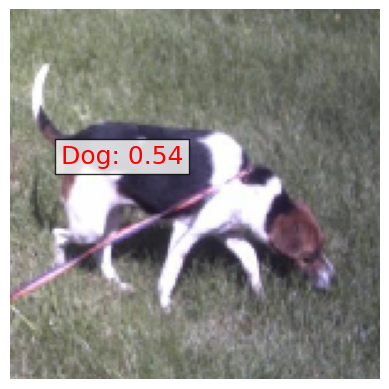

In [39]:
#get random image from train_set_folder
all_files = []
for root, dirs, files in os.walk(train_set_path):
    for file in files:
        all_files.append(os.path.join(root, file))  
img_path = random.choice(all_files)
img1 = image.load_img(img_path, target_size=(150, 150))  # Match target size with training size
img = image.img_to_array(img1)  # Convert image to array
img = img / 255.0  # Normalize the image

# Create a batch of size 1 [N,H,W,C]
img = np.expand_dims(img, axis=0)

# Make prediction
prediction = classifier.predict(img)  # No need for batch_size or steps arguments

# Interpret the prediction
if prediction[0, 0] > 0.5:
    value = 'Dog: %1.2f' % prediction[0, 0]
    plt.text(20, 62, value, color='red', fontsize=18, bbox=dict(facecolor='white', alpha=0.8))
else:
    value = 'Cat: %1.2f' % (1.0 - prediction[0, 0])
    plt.text(20, 62, value, color='red', fontsize=18, bbox=dict(facecolor='white', alpha=0.8))

# Display the image
plt.imshow(img1)
plt.axis('off')  # Hide axes
plt.show()


In [29]:
# Reset the generator before prediction
val_set.reset()
steps = math.ceil(val_set.samples / val_set.batch_size)
# Use predict with steps argument
predictions = classifier.predict(val_set, steps=steps)
df = pd.DataFrame({
    'filename': val_set.filenames,
    'predict': predictions.flatten(),
    'y': val_set.classes
})
pd.set_option('display.float_format', lambda x: '%.5f' % x)
df['y_pred'] = df['predict']>0.5
df.y_pred = df.y_pred.astype(int)
df.head(10)

157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step


,filename,predict,y,y_pred
0,cat/cat.100.jpg,0.52826,0,1
1,cat/cat.1000.jpg,0.53345,0,1
2,cat/cat.10000.jpg,0.51597,0,1
3,cat/cat.10010.jpg,0.51127,0,1
4,cat/cat.10017.jpg,0.51587,0,1
5,cat/cat.10022.jpg,0.52739,0,1
6,cat/cat.10024.jpg,0.51606,0,1
7,cat/cat.10031.jpg,0.51321,0,1
8,cat/cat.10040.jpg,0.51437,0,1
9,cat/cat.10051.jpg,0.51687,0,1


In [32]:
misclassified = df[df['y']!=df['y_pred']]
print('Total misclassified image from 5000 Validation images : %d'%misclassified['y'].count())

Total misclassified image from 5000 Validation images : 2483


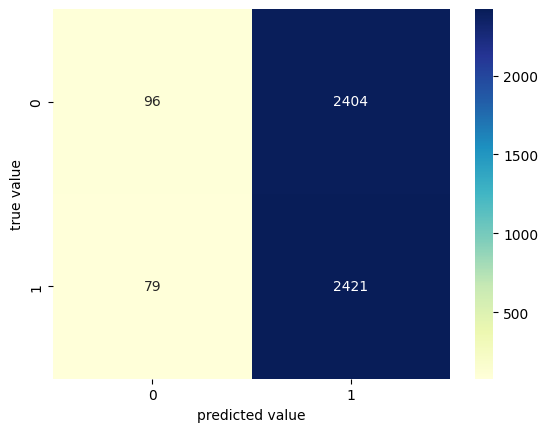

In [33]:
conf_matrix = confusion_matrix(df.y,df.y_pred)
sns.heatmap(conf_matrix,cmap="YlGnBu",annot=True,fmt='g');
plt.xlabel('predicted value')
plt.ylabel('true value');

In [10]:
classifier.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,485,445 (55.26 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,656,964 (36.84 MB)

### Model Performance on Unseen Data

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


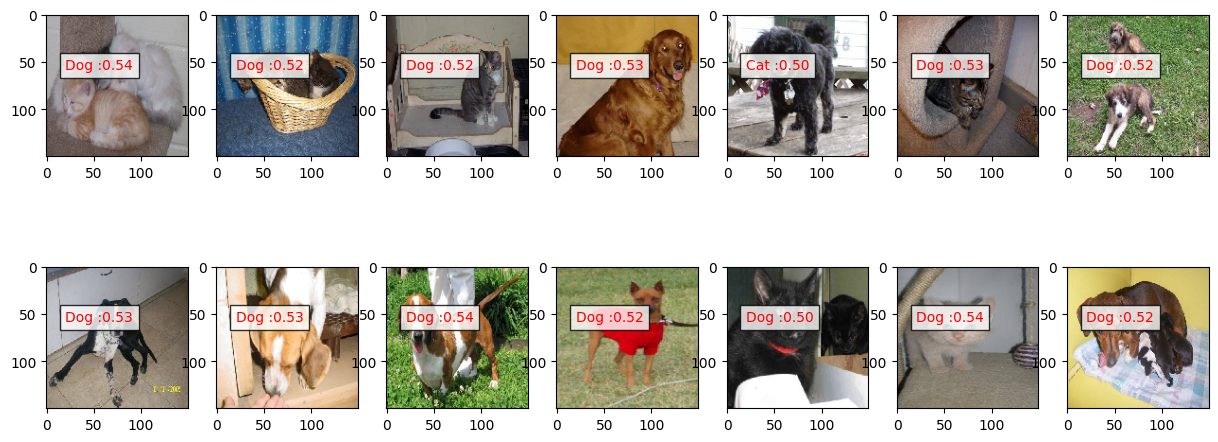

In [40]:
fig=plt.figure(figsize=(15, 6))
columns = 7
rows = 2
for root, dirs, files in os.walk(test_set_path):
    for i in range(columns*rows):
        fig.add_subplot(rows, columns, i+1)
        img_path = f'{test_set_path}/{i+1}.jpg' 
        # Load and preprocess the image
        img1 = image.load_img(img_path, target_size=(150, 150))
        img = image.img_to_array(img1)
        img = img/255
        img = np.expand_dims(img, axis=0)
        prediction = classifier.predict(img, batch_size=None,steps=1) #gives all class prob.
        if(prediction[:,:]>0.5):
            value ='Dog :%1.2f'%(prediction[0,0])
            plt.text(20, 58,value,color='red',fontsize=10,bbox=dict(facecolor='white',alpha=0.8))
        else:
            value ='Cat :%1.2f'%(1.0-prediction[0,0])
            plt.text(20, 58,value,color='red',fontsize=10,bbox=dict(facecolor='white',alpha=0.8))
        plt.imshow(img1)


In [41]:
# Model Accuracy
x1 = classifier.evaluate(train_set) 
x2 = classifier.evaluate(val_set)  
print('Training Accuracy  : %1.2f%%     Training loss  : %1.6f'%(x1[1]*100,x1[0]))
print('Validation Accuracy: %1.2f%%     Validation loss: %1.6f'%(x2[1]*100,x2[0]))

108/625 ━━━━━━━━━━━━━━━━━━━━ 47s 91ms/step - accuracy: 0.4987 - loss: 0.6933

KeyboardInterrupt: 

### Get predictions of test dataset 

In [42]:
predictions =  []
for file in os.listdir(test_set_path):
    img_path = os.path.join(test_set_path, file)
    img = image.load_img(img_path, target_size=(150, 150))
    img = image.img_to_array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    prediction = classifier.predict(img)
    if prediction[0, 0] > 0.5:
        value = 'Dog'
    else:
        value = 'Cat'
    predictions.append({'filename': file, 'prediction': prediction[0, 0], 'class': value})
predictions = pd.DataFrame(predictions)
predictions.to_csv(f'{datetime.now().strftime("%Y%m%d_%H-%M-%S")}_predictions.csv', index=False)  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━